In [1]:
import tensorflow as tf
import numpy as np
na = np.newaxis

import matplotlib.pyplot as plt

# Tensorflow Test

In [2]:
# inducing point locations
Z = np.linspace(0, 10, 11)[:,na]

In [3]:
# https://github.com/GPflow/GPflow/issues/439
def tf_tril_indices(N, k=0):
    M1 = tf.tile(tf.expand_dims(tf.range(N), axis=0), [N,1])
    M2 = tf.tile(tf.expand_dims(tf.range(N), axis=1), [1,N])
    mask = (M1-M2) >= -k
    ix1 = tf.boolean_mask(M2, tf.transpose(mask))
    ix2 = tf.boolean_mask(M1, tf.transpose(mask))
    return ix1, ix2

In [4]:
def ard_kernel(X1, X2, gamma=1., alphas=None):
    # X1:  (n1 x d)
    # X2:  (n2 x d)
    # out: (n1 x n2
    with tf.name_scope('ard_kernel'):
        if alphas is None:
            alphas = tf.ones([tf.shape(X1)[1]])
        return gamma * tf.reduce_prod(tf.exp(- (tf.expand_dims(X1, 1) - tf.expand_dims(X2, 0))**2 / (2 * tf.expand_dims(tf.expand_dims(alphas, 0), 0))), axis=2) 

def kl_term(m, S, K_zz, K_zz_inv, u_ovln):
    # mean_diff = (u_ovln * tf.ones([tf.shape(Z_ph)[0]]) - m)
    mean_diff = tf.expand_dims(u_ovln * tf.ones([tf.shape(Z_ph)[0]]) - m, 1)
    first  = tf.trace(tf.matmul(K_zz_inv, S))
    second = tf.log(tf.matrix_determinant(K_zz) / tf.matrix_determinant(S))
    third  = tf.to_float(tf.shape(m)[0])
    # fourth = tf.reduce_sum(tf.multiply(tf.reduce_sum(tf.multiply(mean_diff, tf.transpose(K_zz_inv)), axis=1) , mean_diff))
    
    fourth = tf.squeeze(tf.matmul(tf.matmul(tf.transpose(mean_diff), K_zz_inv), mean_diff))
    
    return 0.5 * (first  + second - third + fourth)

In [5]:
tf.reset_default_graph()

Z_ph = tf.placeholder(tf.float32, [None, None], name='inducing_point_locations')
u_ph = tf.placeholder(tf.float32, [],           name='inducin_point_mean')
n_ph = tf.placeholder(tf.int32,   [],           name='number_samples')


num_inducing_points = 11 # tf.shape(Z_ph)[0] TODO: use shape of Z_ph instead? Right now, the number is defined twice (once here, one above in the definition of Z)

# mean
m_init = tf.ones([num_inducing_points])
m = tf.Variable(m_init)

# vectorized version of covariance matrix S (ensure valid covariance matrix)
vech_size   = (num_inducing_points * (num_inducing_points+1)) / 2 
vech_indices= tf.transpose(tf_tril_indices(num_inducing_points))
L_vech_init = tf.ones([vech_size])
L_vech = tf.Variable(L_vech_init)
L_shape = tf.constant([num_inducing_points, num_inducing_points])
L_st = tf.SparseTensor(tf.to_int64(vech_indices), L_vech, tf.to_int64(L_shape))
L = tf.sparse_add(tf.zeros(L_shape), L_st)
S = tf.matmul(L, tf.transpose(L))

# kernel calls
K_zz  = ard_kernel(Z_ph, Z_ph)
K_zz_inv = tf.matrix_inverse(K_zz)

with tf.name_scope('approximation'):
    kl_term_op = kl_term(m, S, K_zz, K_zz_inv, u_ph)
    tf.summary.scalar('kl_div', kl_term_op)
    
with tf.name_scope('optimization'):
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(kl_term_op)

with tf.name_scope('prior_sampling'):
    cov  = K_zz
    mean = u_ph * tf.ones([num_inducing_points])
    ind_point_dist = tf.contrib.distributions.MultivariateNormalFullCovariance(mean, cov)
    samples = ind_point_dist.sample(n_ph)
    
m_grad = tf.gradients(kl_term_op, [m])[0]  
L_vech_grad = tf.gradients(kl_term_op, [L_vech])[0]

    
merged = tf.summary.merge_all()

..........
14.884
11.0
True
..........
4.87401
5.19268
True
..........
1.998
2.79538
True
..........
0.831578
1.84
True
..........
0.348902
1.39674
True
..........
0.14716
1.19772
True
..........
0.062305
1.10509
True
..........
0.0264568
1.05745
True
..........
0.0112598
1.03331
True
..........
0.00480091
1.01996
True
..........
0.00205105
1.01223
True
..........
0.000878231
1.00772
True
..........
0.000373582
1.00491
True
..........
0.000161391
1.00316
True
..........
6.93522e-05
1.00205
True
..........
2.89407e-05
1.00133
True
..........
1.32284e-05
1.00086
True
..........
3.99978e-06
1.00056
True
..........
1.18396e-06
1.00037
True
..........
3.09522e-07
1.00024
True
..........
1.35494e-07
1.00016
True
..........
-4.17521e-07
1.0001
True
..........
-4.50869e-07
1.00007
True
..........
1.13691e-08
1.00005
True
KL is zero after 2317 iterations... break


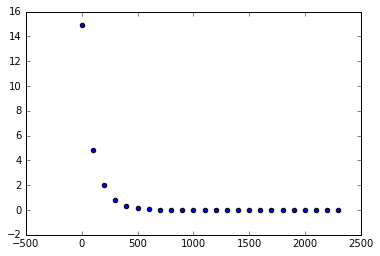

In [12]:
max_iterations = 100000

wr_means = []
wr_covar = []

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('logs', sess.graph)
    
    for i in range(max_iterations):
        _, summary, kl, m_val, S_val = sess.run([train_step, merged, kl_term_op, m, S], feed_dict={Z_ph:Z, u_ph:0.})
        writer.add_summary(summary, i)
        
        if i % 100 == 0:
            print('..........')
            print(kl)
            print(np.max(np.absolute(S_val)))
            print(np.all(np.linalg.eigvals(S_val) > 0))
            
            plt.scatter(i, kl)
            
        if np.isclose(kl, 0):
            print('KL is zero after {} iterations... break'.format(i))
            break
            
plt.show()

In [7]:
def ard_kernel_np(X1, X2, gamma = 1., alphas = None):
    
    if alphas == None:
        alphas = np.ones(X1.shape[1])
    
    return gamma * np.prod(np.exp( - (X1[:,None,:] - X2[None,:,:])**2 / (2 * alphas[None,None,:])), axis=2)

In [8]:
# TEST

r_mean = np.zeros(num_inducing_points)
r_cov = ard_kernel_np(Z, Z)

print(np.allclose(r_mean, m_val))
print(np.allclose(r_cov, S_val))

print(np.sum(r_cov - S_val)**2)

# values not allclose but almost the same

False
False
4.25620327397e-05


### example sampling:

In [9]:
# sampling
num_samples = 10

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('logs', sess.graph)
    sample_res, mean_res, cov_res = sess.run([samples, mean, cov], feed_dict={Z_ph:Z, u_ph:0., n_ph:num_samples})

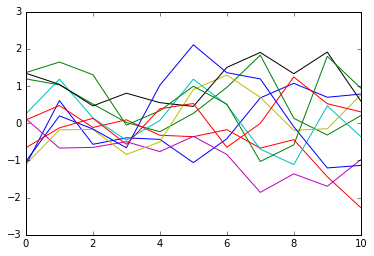

In [10]:
for i in range(num_samples):
    plt.plot(Z, sample_res[i])
plt.show()

# Planning:

# 1. Inputs:
Domain $X = \mathbb{R}^R$ ($R$-Dimensional)
$T \subset X$


### Fixed:

#### General:
- R
- Tlims: (Rx2)
- Data D: (NxR) (all points in T)

#### Inducing points:
    -> fix nbr M 
    -> Z: (MxR) location
    -> u: (M) (each sample of function values at the inducing points is M dimensional) 

#### Hyperparameters ($\Theta$)
    -> fixed at first, might become be optimized later as well
$\Theta = (\gamma, \alpha_1,...,  \alpha_R, \overline{u})$


### Parameters:
variational dist at inducing points u: q(u) = N (u;m,S)

m: (M)

S: (MxM)

In [11]:
# pseudo stuff, no working code!!!

# constants:
# - R, T, M
# - D (NxR)
# - Z (MxR)
# - Theta values (gamma, alphas, ustrich)

# placeholders:
# - m (M)
# - S (MxM)


# kernel stuff:

def kernel_function(X, Y):
    return K_XY

# kernels to compute: K_zz, K_zd, trace(K_dd)

def lower_bound(D, m, S, Theta, T):
    K_zz = ...
    K_zz_inv = ...
    
    return - region_integral(m, S, K_zz_inv, Z, Theta, T) + datapoint_expectations(D, m, S, K_zz_inv, Theta) - kl_term(m,S,K_zz, K_zz_inv, Theta) 

def kl_term(m, S, K_zz, K_zz_inv, Theta):
    return scalar_value_node

def datapoint_expectations(D, m, S, K_zz_inv, Theta):
    
    k_zd = ...
    k_dd = ...
    
    musqare_N = ...
    sigsquare_N = ...
    
    C = 0.57721... #Euler-Masceroni constant
    
    lookup values = ... # problem: how to implement lookup table
    
    return scalar_value_node

def region_integral(m, S, K_zz_inv, Z, Theta, T):
    Psi = ... (MxM) 
    return scalar_value_node

SyntaxError: invalid syntax (<ipython-input-11-aa9d15269d05>, line 38)